### note: run deidentification on dup image data

In [1]:
# https://stanfordmlgroup.github.io/competitions/chexpert/

### imports

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
torch.backends.cudnn.benchmark = True

In [4]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/tmp'),
 PosixPath('../../data/siim_acr_pneu/preds'),
 PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [5]:
torch.cuda.set_device(1)

In [6]:
chx_mimic_stats = [tensor([0.485, 0.456, 0.406]), tensor([0.229, 0.224, 0.225])]

### databunch

In [7]:
sz,bs = 1024,4
tfms = get_transforms()
data = (ImageList.from_csv(data_path, 'clas_df.csv', folder=f'train/images_{sz}', suffix='.jpg')
        .split_by_rand_pct(0.1, seed=42)
        .label_from_df()
        .transform(tfms=tfms, size=sz) 
        .databunch(bs=bs)
        .normalize(chx_mimic_stats) # if chexpert finetuning imagenet otherwise
     )

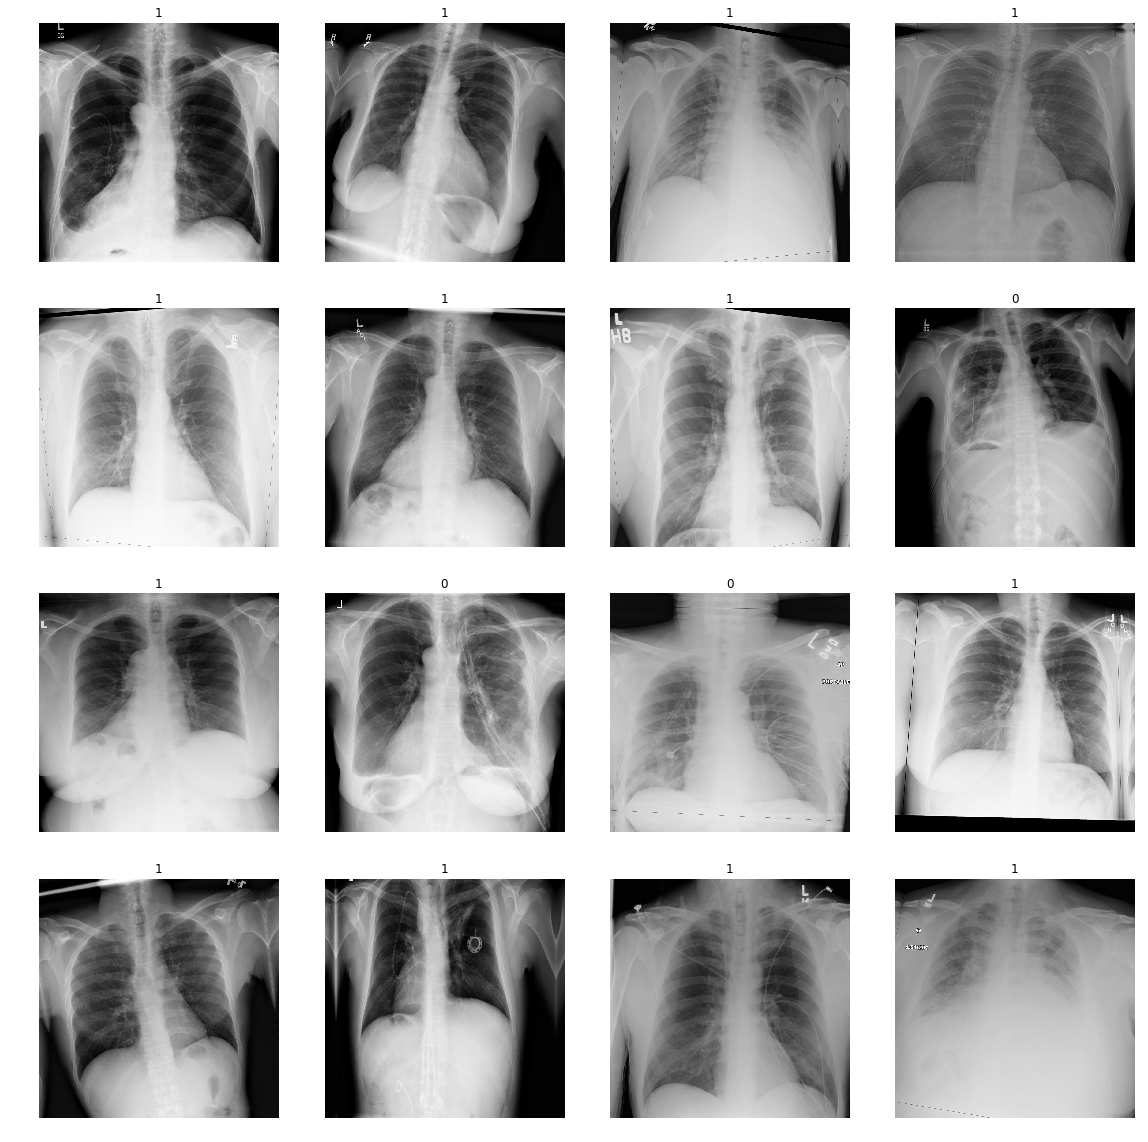

In [8]:
# data.show_batch()

In [8]:
data

ImageDataBunch;

Train: LabelList (10424 items)
x: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: CategoryList
1,0,0,0,0
Path: ../../data/siim_acr_pneu;

Valid: LabelList (1158 items)
x: ImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
y: CategoryList
0,0,1,1,1
Path: ../../data/siim_acr_pneu;

Test: None

In [9]:
len(data.train_ds), len(data.valid_ds)

(10424, 1158)

### model

In [10]:
def _xresnet_split(m:nn.Module): return (m[6], m[8])

In [11]:
pretrained = True

In [17]:
if pretrained: learn = cnn_learner(data, models.densenet121, pretrained=pretrained)
else: learn = Learner(data, models.xresnet34(c_out=data.c)); learn.split(_xresnet_split)
learn.metrics = [accuracy, AUROC()]

In [18]:
learn.model[-1][-1].weight.shape

torch.Size([2, 512])

In [20]:
learn.model.state_dict().keys()

odict_keys(['0.0.conv0.weight', '0.0.norm0.weight', '0.0.norm0.bias', '0.0.norm0.running_mean', '0.0.norm0.running_var', '0.0.norm0.num_batches_tracked', '0.0.denseblock1.denselayer1.norm1.weight', '0.0.denseblock1.denselayer1.norm1.bias', '0.0.denseblock1.denselayer1.norm1.running_mean', '0.0.denseblock1.denselayer1.norm1.running_var', '0.0.denseblock1.denselayer1.norm1.num_batches_tracked', '0.0.denseblock1.denselayer1.conv1.weight', '0.0.denseblock1.denselayer1.norm2.weight', '0.0.denseblock1.denselayer1.norm2.bias', '0.0.denseblock1.denselayer1.norm2.running_mean', '0.0.denseblock1.denselayer1.norm2.running_var', '0.0.denseblock1.denselayer1.norm2.num_batches_tracked', '0.0.denseblock1.denselayer1.conv2.weight', '0.0.denseblock1.denselayer2.norm1.weight', '0.0.denseblock1.denselayer2.norm1.bias', '0.0.denseblock1.denselayer2.norm1.running_mean', '0.0.denseblock1.denselayer2.norm1.running_var', '0.0.denseblock1.denselayer2.norm1.num_batches_tracked', '0.0.denseblock1.denselayer2.con

In [14]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace)
   (9): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace)
   (15): Conv2d(128, 32, kernel_s

In [14]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 512, 512]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 512, 512]       128        True      
______________________________________________________________________
ReLU                 [64, 512, 512]       0          False     
______________________________________________________________________
MaxPool2d            [64, 256, 256]       0          False     
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [128, 256, 256]      8,192      False     
___________________________________________________

In [15]:
# LOAD PRETRAINED WEIGHTS
chx_state_dict = torch.load("/home/turgutluk/data/models/chx-mimic-only-pneumo-densenet121-320.pth")

In [16]:
chx_state_dict.keys()

dict_keys(['0.0.conv0.weight', '0.0.norm0.weight', '0.0.norm0.bias', '0.0.norm0.running_mean', '0.0.norm0.running_var', '0.0.norm0.num_batches_tracked', '0.0.denseblock1.denselayer1.norm1.weight', '0.0.denseblock1.denselayer1.norm1.bias', '0.0.denseblock1.denselayer1.norm1.running_mean', '0.0.denseblock1.denselayer1.norm1.running_var', '0.0.denseblock1.denselayer1.norm1.num_batches_tracked', '0.0.denseblock1.denselayer1.conv1.weight', '0.0.denseblock1.denselayer1.norm2.weight', '0.0.denseblock1.denselayer1.norm2.bias', '0.0.denseblock1.denselayer1.norm2.running_mean', '0.0.denseblock1.denselayer1.norm2.running_var', '0.0.denseblock1.denselayer1.norm2.num_batches_tracked', '0.0.denseblock1.denselayer1.conv2.weight', '0.0.denseblock1.denselayer2.norm1.weight', '0.0.denseblock1.denselayer2.norm1.bias', '0.0.denseblock1.denselayer2.norm1.running_mean', '0.0.denseblock1.denselayer2.norm1.running_var', '0.0.denseblock1.denselayer2.norm1.num_batches_tracked', '0.0.denseblock1.denselayer2.conv

In [22]:
# load state dict from chx model until last layer group
for n, p in list(learn.model[:-1].named_parameters()): p.data = chx_state_dict[n].to(torch.device('cuda'))

In [23]:
baseline = learn.data.valid_ds.y.items.mean(); print(f"baseline: {baseline}")

baseline: 0.6934369602763385


In [17]:
learn.to_fp16(); learn.freeze()

In [21]:
# learn.callbacks.append(SaveModelCallback(learn, monitor='auroc', name=f"clas-densenet121-{sz}-{fold_idx}"))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


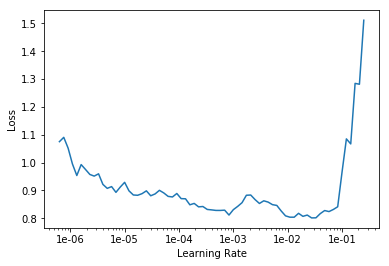

In [18]:
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.metrics = [accuracy, AUROC()]

In [50]:
lr = 1e-2

In [51]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.410734,0.476833,0.815676,0.899738,05:31
1,0.390748,0.453559,0.785530,0.904266,05:30
2,0.354471,0.360901,0.835487,0.913897,05:31
3,0.312241,0.304340,0.868217,0.931611,05:30
4,0.290008,0.299597,0.867356,0.933624,05:31


In [52]:
learn.freeze_to(-1)

In [53]:
learn.fit_one_cycle(10, slice(lr/2))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.296057,0.300479,0.869078,0.933287,05:11
1,0.311293,0.304009,0.868217,0.933275,05:52
2,0.277594,0.293121,0.875969,0.936567,05:51
3,0.313392,0.295299,0.875108,0.935937,06:22
4,0.298278,0.289698,0.876830,0.937690,06:23


In [54]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(5, slice(lr/5))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.311451,0.291833,0.873385,0.938501,08:05
1,0.283024,0.288138,0.875969,0.938971,08:09
2,0.277777,0.291121,0.878553,0.937846,07:11
3,0.292038,0.288781,0.881137,0.939381,06:40
4,0.266440,0.287534,0.878553,0.940551,06:39


In [56]:
learn.fit_one_cycle(5, slice(lr/10))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.272654,0.287714,0.878553,0.939716,07:10
1,0.280453,0.286833,0.883721,0.939881,07:26
2,0.268220,0.280857,0.883721,0.941788,07:12
3,0.243901,0.284905,0.879414,0.941012,06:56
4,0.275949,0.282237,0.883721,0.942141,06:54


In [57]:
learn.to_fp32();

In [58]:
# learn.save(f"clas-resnet34-{sz}")
# learn.save(f"clas-chexpert-ft-resnet34-{sz}")
learn.save(f"clas-chexpert-ft-resnext34-{sz}")
# learn.save(f"clas-densenet121-{sz}")
# learn.save(f"clas-chexpert-ft-densenet121-{sz}")

In [59]:
learn.validate(learn.data.valid_dl)

[0.2822237, tensor(0.8837), tensor(0.9421)]

### add test

In [60]:
test = ImageList.from_folder(data_path/f'test/images_{sz}', extensions='.jpg')

In [61]:
learn.data.add_test(test)

In [62]:
# learn.load(f"clas-resnet34-{sz}");
# learn.load(f"clas-chexpert-ft-resnet34-{sz}");
learn.load(f"clas-chexpert-ft-resnext34-{sz}");
# learn.load(f"clas-densenet121-{sz}");
# learn.load(f"clas-chexpert-ft-densenet121-{sz}");

### save all learn obj

In [63]:
os.makedirs(data_path/"learn", exist_ok=True)

In [64]:
with ModelOnCPU(learn.model) as model:
#     try_save({"data":learn.data, "model":model}, data_path, f"learn/clas-chexpert-ft-resnet34-{sz}")
    try_save({"data":learn.data, "model":model}, data_path, f"learn/clas-chexpert-ft-resnext34-{sz}")
#     try_save({"data":learn.data, "model":model}, data_path, f"learn/clas-densenet121-{sz}")
#     try_save({"data":learn.data, "model":model}, data_path, f"learn/clas-chexpert-ft-densenet121-{sz}")

### interpret

In [65]:
from sklearn.metrics import roc_auc_score, f1_score

In [66]:
preds, targs = learn.get_preds(DatasetType.Valid)

In [67]:
roc_auc_score(targs, preds[:,1])

0.9421207507393201

In [68]:
f1_score(targs, preds[:,1] > 0.3)

0.915099715099715

In [69]:
interp = learn.interpret()

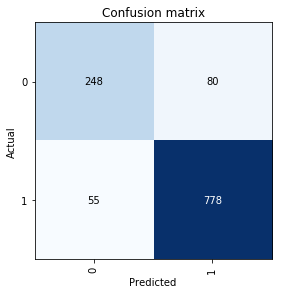

In [70]:
interp.plot_confusion_matrix()